# Estado Estacionário

## Sobre a modelagem

As bibliotecas *Numpy* e *MatPlotLib* devem ser importadas para que tenhamos métodos para calcular as equações e Plotar a dinâmica, respectivamente.

O artigo apresenta a modelagem de um sistema CSTR através das seguintes equações, no estado estacionário:

$$
F_o(C_{Ao} - C_A) - VkC_A = 0 
$$ 

$$ 
\rho C_pF_o(T_o-T_j) - \lambda VkC_A - UA(T - T_j) = 0
$$

$$
\rho_j C_jF_j(T_{jo}-T_j)+UA(T - T_j) = 0
$$

Ocorre que $k = \alpha e^{E/RT}$ , o que nos leva a reescrever as duas primeiras equações como:

$$
F_o(C_{Ao} - C_A) - V \alpha e^{E/RT} C_A = 0
$$ 

$$ 
\rho C_pF_o(T_o-T_j) - \lambda V \alpha e^{E/RT} C_A - UA(T - T_j) = 0
$$

Fazemos isso para obter três equações e três variáveis para as quais devemos resolver essas equações, a saber: $T$ , $C_j$ e $T_j$. Sendo assim, temos um sistema de equações não lineares. 

É preciso notar que essas equações podem ter múltiplas soluções. Sendo assim, a resolução direta dessas equações não nos fornecerá todos os estados estacionários — como o próprio artigo argumenta —, mas bastará para os objetivos desta demonstração. Além disso, os estados estacionários dependem da temperatura de entrada do fluido, que vamos tratar como uma constate $T_o = 530°C$

Logo, o que faremos é: *Encontrar pelo menos uma solução de estado estacionário*

## Bibliotecas

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import fsolve
from math import exp

## Parâmetros

In [ ]:
# VARIAVEIS DO REATOR

CAo    = 0.5    # Concentração do fluido A na entrada;
rho    = 50.0    # Densidade do fluido A;
U      = 150.0    # Energia;
A      = 250.0    # Área do reator;
V      = 48.0    # Volume interno do Reator;
Fi     = 40.0    # Fluxo na saída do reator;
Fo     = 40.0    # Fluxo na entrada do reator;
To     = 530.0

# VARIAVEIS DA CAMISA

Fj     = 49.9    # Fluxo da camisa;
Vj     = 3.85    # Volume da camisa;
Cj     = 1.0       # Concentração do fluido refrigerante
Cp     = 0.75
rhoj   = 62.3    # Densidade do fluido refrigerante;
Toj    = 530.0

# CONSTANTES DA REAÇÂO

lbd     = -3e4     
E       = 3e4        # activation energy J/gmol
R       = 1.99      # gas constant J/gmol/K
k0      = 7.8e10    # Arrhenius rate constant 1/min

## Encontrando o Estado estacionário

In [ ]:
# Cálculo da taxa de reação de Arrhenius
def k(T):
    return k0 * np.exp(-E/R/T)

# Função que implementa o sistema de equações do nosso problema
def SistemaEquacoes(vars):
    T, Tj, Ca = vars
    eq1 = Fo * (CAo - Ca) - V * k(T) * Ca
    eq2 = rho * Cp * Fo * (To - T) - lbd * k(T) * Ca - U * A * (T - Tj)
    eq3 = rhoj * Cj * Fj * (Toj-Tj) + U * A * (T - Tj)
    return [eq1, eq2, eq3]

    # Condições iniciais
T      = 500.0    # Temperatura interna do reator;
Tj     = 500.0    # Temperatura interna do reator;
Ca     = 0.5    # Concentração do fluido A na Saída;

# Solution, infodict, ier, mesg = fsolve(SistemaEquacoes, [T, Tj, Ca], full_output=True)
print(fsolve(SistemaEquacoes, [T, Tj, Ca], full_output=True))

# Dinâmica

Faremos o cálculo pelo método de Euler, para isso é necessário arrumar as equações de modo que a dinâmica (diferenciais) fiquem de um lado isolados. Ou seja:

$$
\frac{dC_A}{dt}= \frac{F_o}{V}(C_{Ao} - C_A) - kC_A
$$ 

$$ 
\frac{dT}{dt}= \frac{F_o}{V}(T_o-T) - \frac{C_A}{\rho C_p}\lambda k - \frac{UA}{\rho C_p V}(T - T_j)
$$

$$
\frac{dT_j}{dt}= \frac{F_j}{V_j}(T_{jo}-T_j) + \frac{UA}{\rho_j C_j V_j} (T - T_j)
$$



## Bibliotecas

In [9]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from math import exp

## Parâmetros

In [10]:
    # VARIAVEIS DO REATOR

CAo    = 0.5    # Concentração do fluido A na entrada;
rho    = 50.0    # Densidade do fluido A;
_u      = 150.0    # Energia;
_a      = 250.0    # Área do reator;
_v      = 48.0    # Volume interno do Reator;
Fi     = 40.0    # Fluxo na saída do reator;
Fo     = 40.0    # Fluxo na entrada do reator;
To     = 530.0
lbd     = -3e4 

    # VARIAVEIS DA CAMISA

Fj     = 49.9    # Fluxo da camisa;
Vj     = 3.85    # Volume da camisa;
Cj     = 1.0       # Concentração do fluido refrigerante
Cp     = 0.75
rhoj   = 62.3    # Densidade do fluido refrigerante;
Toj    = 530.0


## Simulando a dinâmica

In [ ]:
# Cálculo da taxa de reação de Arrhenius
def k(T):
    E       = 3e4        # activation energy J/gmol
    R       = 1.99      # gas constant J/gmol/K
    k0      = 7.8e10    # Arrhenius rate constant 1/min
    return k0 * np.exp(-E/R/T)

def odes(x,t):

    Ca  = x[0] # Concentração interna do reator;
    Tj  = x[1] # Temperatura interna jaqueta;
    T   = x[2] # Temperatura interna do reator;

    # if T < 800:
    #     ko = k(T)
    # else:
    #     ko = 0.1
    ko = k(T)

    dCadt   = (Fo/_v) * (CAo - Ca) - (ko * Ca)
    dTjdt   = (Fo/_v) * (To - T) - (Ca * lbd * ko)/(rho * Cp) - (_u * _a) * (T - Tj)/(rho * Cp * _v)
    dTdt    = (Fj/Vj) * (Toj - Tj) + (_u * _a) * (T - Tj)/(rhoj * Cj * Vj)

    return dCadt, dTjdt, dTdt

# y, infodict = odeint(odes, x0, t, full_output = True)
# print(infodict["leniw"])

x0 = [50,50,.3]
t = np.linspace(0,15,1000)
x = odeint(odes, x0, t)
print(x)

A = x[:,0]
B = x[:,1]
C = x[:,2]

plt.plot(t,A)
plt.plot(t,B)
plt.plot(t,C)
plt.show()    


# EXTRA: Dinâmica através do método de Euler

(501,)


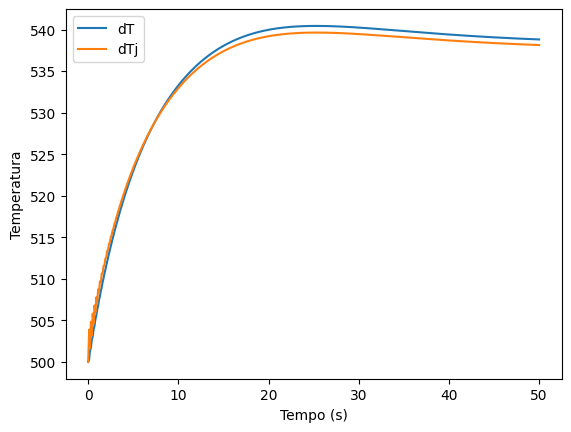

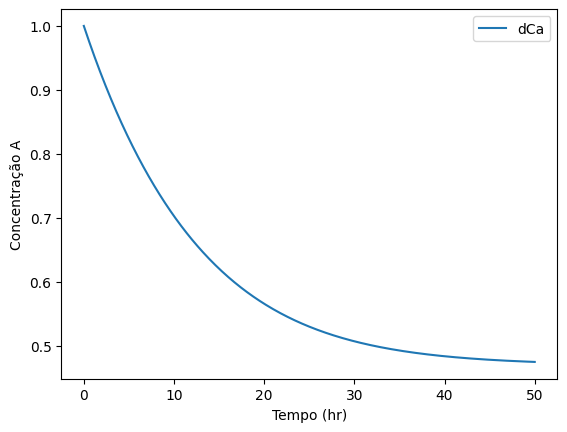

In [35]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from math import exp

    # VARIAVEIS DO REATOR

CAo    = 0.5    # Concentração do fluido A na entrada;
rho    = 50.0    # Densidade do fluido A;
_u      = 150.0    # Energia;
_a      = 250.0    # Área do reator;
_v      = 48.0    # Volume interno do Reator;
Fo     = 40.0    # Fluxo na entrada do reator;
To     = 530.0
lbd     = -3e4 

    # VARIAVEIS DA CAMISA

Fj     = 49.9    # Fluxo da camisa;
Vj     = 3.85    # Volume da camisa;
Cj     = 1.0       # Concentração do fluido refrigerante
Cp     = 0.75
rhoj   = 62.3    # Densidade do fluido refrigerante;
Toj    = 530.0

T   = 500
Tj  = 500
Ca  = 1

Dt = 0.01
t_start = 0             # starttime
t_end = 5              # endtime
n_steps = int(round((t_end-t_start)/Dt))    # number of timesteps

T_arr = np.zeros(n_steps + 1)   # create an array of zeros for Y
Tj_arr = np.zeros(n_steps +1)   # create an array of zeros for P
Ca_arr = np.zeros(n_steps +1)   # create an array of zeros for P

t_arr = np.zeros(n_steps + 1)   # create an array of zeros for t
t_arr[0] = t_start              # add starttime to array
T_arr[0] = T                    # add initial value of Y to array
Tj_arr[0] = Tj                  # add initial value of P to array
Ca_arr[0] = Ca                  # add initial value of P to array

def k(T):
    E       = 3e4        # activation energy J/gmol
    R       = 1.99      # gas constant J/gmol/K
    alfa      = 7.8e10    # Arrhenius rate constant 1/min
    return alfa * np.exp(-E/R/T)


# Euler's method
for i in range (1, n_steps + 1):  
   T = T_arr[i-1]
   Tj = Tj_arr[i-1]
   Ca = Ca_arr[i-1]
   dCadt  = (Fo/_v) * (CAo - Ca) - (k(T) * Ca)
   dTdt   = (Fo/_v) * (To - T) - (Ca * lbd * k(T))/(rho * Cp) - (_u * _a) * (T - Tj)/(rho * Cp * _v)
   dTjdt  = (Fj/Vj) * (Toj - Tj) + (_u * _a) * (T - Tj)/(rhoj * Cj * Vj)
   T_arr[i] = T + Dt*dTdt  # calc. Y at next timestep,add to array
   Tj_arr[i] = Tj + Dt*dTjdt  # calc. P at next timestep,add to array
   Ca_arr[i] = Ca + Dt*dCadt  # add new value of t to array

print(Ca_arr.shape)

t = np.linspace(0,50,501)

plt.plot(t,T_arr,label='dT')
plt.plot(t,Tj_arr,label='dTj')
plt.legend()
plt.xlabel("Tempo (s)")
plt.ylabel("Temperatura")
plt.show()

plt.plot(t,Ca_arr,label='dCa')
plt.legend()
plt.xlabel("Tempo (hr)")
plt.ylabel("Concentração A")
plt.show()
plt.show()

# plotting the result
# fig = plt.figure()                                  # create figure
# plt.plot(t_arr, T_arr, linewidth = 4, label = 'Y')    # plot Y to t 
# plt.plot(t_arr, Tj_arr, linewidth = 4, label = 'P')    # plot P to t
# plt.plot(t_arr, Ca_arr, linewidth = 4, label = 'P')    # plot P to t

# plt.title('Title', fontsize = 12)    # add some title to your plot
# plt.xlabel('t (in seconds)', fontsize = 12)
# plt.ylabel('Y(t), P(t)', fontsize = 12)

# plt.xticks(fontsize = 12)
# plt.yticks(fontsize = 12)
# plt.grid(True)                        # show grid
# plt.axis([t_start, t_end, 0, 10])     # show axes measures
# plt.legend()
# plt.show()